## **Prompt Chaining Workflow**

In [35]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_ollama import ChatOllama

In [36]:
# Graph state
class AgentState(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str

In [37]:
llm = ChatOllama(model="deepseek-v3.1:671b-cloud")

In [38]:
# Nodes
def generate_joke(state: AgentState):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}


# conditional node
def check_punchline(state: AgentState):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    return "Fail"


def improve_joke(state: AgentState):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(
        f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}


def polish_joke(state: AgentState):
    """Third LLM call for final polish"""
    msg = llm.invoke(
        f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}

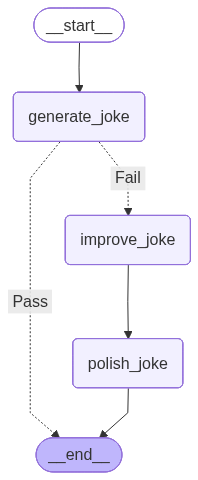

In [39]:
graph = StateGraph(AgentState)

# add nodes
graph.add_node("generate_joke", generate_joke)
graph.add_node("improve_joke", improve_joke)
graph.add_node("polish_joke", polish_joke)

# add edges to connect nodes
graph.add_edge(START, "generate_joke")

graph.add_conditional_edges(
    source="generate_joke",
    path=check_punchline,

    path_map={
        "Fail": "improve_joke",
        "Pass": END
    }
)

graph.add_edge("improve_joke", "polish_joke")
graph.add_edge("polish_joke", END)

app = graph.compile()
app

In [40]:
response = app.invoke({
    "topic": "neil armstrong"
})

In [41]:
print("Initial joke:")
print(response["joke"])
print("\n--- --- ---\n")

if "improved_joke" in response:
    print("Improved joke:")
    print(response["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(response["final_joke"])
else:
    print("Final joke:")
    print(response["joke"])

Initial joke:
Why did Neil Armstrong never get into arguments?

Because he always knew when to walk away.

--- --- ---

Final joke:
Why did Neil Armstrong never get into arguments?

Because he always knew when to walk away.
